In [3]:
import sys, os
import boto3
from datetime import datetime as dt

# EASI defaults
easinotebooksrepo = '/home/jovyan/easi-notebooks'
if easinotebooksrepo not in sys.path: sys.path.append(easinotebooksrepo)
from easi_tools import unset_cachingproxy

In [4]:
import time
import rasterio
import datacube
from datacube.utils.cog import write_cog
import rasterio.warp
from utils import load_data_geo
import geopandas as gpd
from deafrica_tools.areaofinterest import define_area
from datacube.utils.geometry import Geometry
import xarray as xr
import rioxarray
import os, sys
os.environ['USE_PYGEOS'] = '0'
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from dask.distributed import Client, LocalCluster
easinotebooksrepo = '/home/jovyan/easi-notebooks'
if easinotebooksrepo not in sys.path: sys.path.append(easinotebooksrepo)
from easi_tools import EasiDefaults, xarray_object_size, notebook_utils
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
# VH_file = "Sen1_VH_10.21-10.22_update_new.tif"
# VV_file = "Sen1_VV_10.21-10.22_update.tif"

from osgeo import gdal
gdal.UseExceptions()
gdal.PushErrorHandler('CPLQuietErrorHandler')

def load_ctu_s1_data():
    vvpath = 's3://easi-asia-dc-data/staging/ctu/sentinel-1/vv-0922_0923-full_ST.tif'
    vhpath = 's3://easi-asia-dc-data/staging/ctu/sentinel-1/vh-0922_0923-full_ST.tif'
    with unset_cachingproxy():
        vv = rioxarray.open_rasterio(vvpath)
        vh = rioxarray.open_rasterio(vhpath)
        return vv,vh
    
ds, dsvh = load_ctu_s1_data()

In [ ]:
ds_vhvv = xr.concat([ds, dsvh], dim='band')

In [9]:
del ds
del dsvh

In [10]:
train_path = "train/Soc Trang_Traning.shp"
train = load_data_geo(train_path)
train.head()

Name                        geometry
0  Water1  POINT (620223.628 1072681.101)
1  Water1  POINT (621057.521 1071074.602)
2  Water1  POINT (621891.602 1069430.621)
3  Water1  POINT (622762.564 1068048.689)
4  Water1  POINT (623256.484 1066777.765)

In [11]:
loaded_datasets = {}
for idx, point in train.iterrows():
    key = f"point_{idx + 1}"
    try:
        loaded_datasets[key] = {
            "data": ds_vhvv.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values,
            "label": point.Name
                               }
    except Exception as e:
        # loaded_datasets[key] = None
        print(key)

In [12]:
label_encoder = LabelEncoder()

# Fit and transform the labels
labels = train.Name.values
numeric_labels = label_encoder.fit_transform(labels)
label_mapping = dict(zip(labels, numeric_labels))

In [13]:
label_mapping

{'Water1': 2,
 'Water': 1,
 'Urban1': 0,
 'tomlua': 9,
 'rice12': 8,
 'rice11': 7,
 'mia': 6,
 'cln1': 5,
 'cln': 4,
 'chn1': 3}

In [14]:
X = []
for k, v in loaded_datasets.items():
    X.append(v)

In [15]:
x_new = []
lb_new = []
for i in range(len(X)):
    if X[i] is not None:
        x_new.append(X[i]['data'])
        lb_new.append(numeric_labels[i])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x_new, lb_new, test_size=0.3, random_state=42)

In [19]:
# Tạo RandomForestClassifier mặc định để sử dụng làm mô hình ban đầu trong pipeline
base_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Tạo pipeline
pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', base_model),
])

# Thiết lập các tham số bạn muốn tối ưu hóa
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [2, 4, 6],
    'classifier__criterion': ['gini', 'entropy'],
}

# Sử dụng GridSearchCV để tìm bộ tham số tốt nhất
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# In ra bộ tham số tốt nhất
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Dự đoán trên tập kiểm tra
y_pred = grid_search.predict(X_test)

# Đánh giá kết quả
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 6, 'classifier__n_estimators': 300}
Accuracy: 0.6424050632911392


In [23]:
tmp = -1 * np.ones((8874, 9902))
result = []
for i in range(ds_vhvv.shape[1]):
    result.extend(ds_vhvv.isel(y=i).values.T)
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [24]:
num_parts = 5
split_arrays = np.array_split(result, num_parts, axis=0)

In [25]:

y_pred = []
t = time.time()
for d in split_arrays:
    kq = grid_search.predict(d)
    y_pred.append(kq)
    print(f"{time.time() - t}")
    t = time.time()

88.65073561668396
89.57659387588501
88.50649929046631
87.9844377040863
88.20552492141724


In [26]:
final_label = y_pred[0]
for i in y_pred[1:]:
    final_label = np.concatenate((final_label, i), axis=0)

In [27]:
final_label = final_label.reshape(8874, 9902)

In [28]:
from shapely.geometry import Point, Polygon
from pyproj import CRS

In [33]:
final_xarray = xr.DataArray(final_label, dims=("y", "x"))

In [34]:
final_xarray

<xarray.DataArray (y: 8874, x: 9902)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Dimensions without coordinates: y, x

In [36]:
final_xarray.rio.write_crs(ds_vhvv.rio.crs)

<xarray.DataArray (y: 8874, x: 9902)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
    spatial_ref  int64 0
Dimensions without coordinates: y, x

In [73]:
x_values = ds_vhvv.x.values
y_values = ds_vhvv.y.values

In [74]:
data_array = xr.DataArray(final_xarray,
                          coords={'x': x_values, 'y': y_values},
                          dims=['y', 'x'])


In [76]:
data_array.rio.write_crs(ds_vhvv.rio.crs)

<xarray.DataArray (y: 8874, x: 9902)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
    spatial_ref  int64 0

In [79]:
df = data_array.to_dataframe(name='value').reset_index()

In [82]:
df.head()

y         x  value
0  1105735.0  554795.0      0
1  1105735.0  554805.0      0
2  1105735.0  554815.0      0
3  1105735.0  554825.0      0
4  1105735.0  554835.0      0

In [89]:
geometry = [Point(x, y) for x, y in zip(df['x'], df['y'])]
gdf = gpd.GeoDataFrame(df["value"], geometry=geometry, crs="EPSG:4326")

In [ ]:
gdf.head()

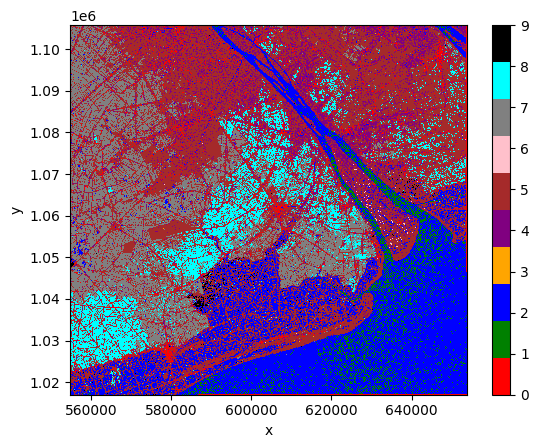

In [102]:
from matplotlib.colors import ListedColormap
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'yellow']
cmap = ListedColormap(colors)
data_array.plot(cmap=cmap)

In [97]:
label_mapping

{'Water1': 2,
 'Water': 1,
 'Urban1': 0,
 'tomlua': 9,
 'rice12': 8,
 'rice11': 7,
 'mia': 6,
 'cln1': 5,
 'cln': 4,
 'chn1': 3}